### Part 2: Fitting RL models
In this tutorial we will learn how implement agents that make decisions that are based on their previous experience.

The code is related to:

Bob Wilson & Anne Collins (2019) eLife: Ten simple rules for the computational modeling of behavioral data.

In this paper, the authors describe a 2-armed bandit, where a player performs $T$ choices between two options. The machine has asymmetric reward probabilities $\mu_{1} = 0.2$ and $\mu_{2} = 0.8$ associated with each arm, which are initially unknown to the player.

We want to find out: Which strategy does a subject use to maximize their overall reward on this machine?

Let's start by importing some modules and making sure the `models.py` module with the helper functions is properly imported if you're working on Colab.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm

# Download the custom library - do this manually if not running on google colab
MODULE_NAME = "models.py"
if not os.path.isfile("models.py"):
    MODULE_URL = f'https://raw.githubusercontent.com/bambschool/BAMB2024/main/day2_reinforcement_learning/part2_fitting_rl_models/{MODULE_NAME}'
    !wget -O {MODULE_NAME} "{MODULE_URL}"

### 1. Set experiment parameters

In [2]:
# set numpy seed to 0
np.random.seed(0)

In [3]:
# Experiment parameters
num_trials = 100
reward_probabilities = np.array([0.2, 0.8])
num_repetitions = 110

### 2. Simulate our candidate models.

We will consider three different normative models of how subjects might attack the problem of maximizing reward on a 2-armed bandit. You can read the mathematical formulation of each model in the paper. Shortly, the proposed models are:

- **Noisy win-stay-lose-shift**: Rewarded actions are repeated, unrewarded actions lead to the player choosing a different arm in the next trial. Every now and then, the subject explores a different option (model 2 with 1 parameter, $\epsilon$, describing the overall level of randomness)

- **Rescorla Wagner**: In each trial, subjects update the expected values of each option (Q), based on the history of previous outcome. Then, they use these values to make the next decision. Every now and then, they explore the low-value option (model 3 with 2 parameters: learning rate $\alpha_{RW}$, softmax inverse temperature $\beta_{RW}$)

- **Choice kernel**: Subjects have a tendency to repeat responses, the strength of which depends on the history of actions they took before the current trial, which is tracked in the "choice kernel" (model 4 with 2 parameters, choice-kernel learning rate $\alpha_{CK}$, choice-kernel inverse temperature $\beta_{CK}$)

### 2.1. Initialize the models

The models are already defined in `models.py`. Let's import and initialize them.

In [4]:
from models import WinStayLoseSwitch, RescorlaWagner, ChoiceKernel

# Initialize models
wsls_model = WinStayLoseSwitch()
rw_model = RescorlaWagner()
ck_model = ChoiceKernel()

### 2.1.1. (Optional) Implement Rescorla Wagner

While all models are coded up in `models.py`, try defining the Rescorla Wagner model yourself. Take a look at the structure of the other models in `models.py` and especially the abstract base class which defines the structure of the models `RLModel`. 

Now, fill out the relevant methods in the model below and see how your definitions compares with the one in `models.py`.

In [ ]:
from models import RLModel

class RescorlaWagner(RLModel):
    def simulate(self, T, mu, alpha, beta):
        Q = np.array([0.5, 0.5])
        a, r = [], []

        for _ in range(T):
            p = np.exp(beta * Q) / np.sum(np.exp(beta * Q))
            a.append(np.random.choice(2, p=p))
            r.append((np.random.random() < mu[a[-1]]).astype(float))

            delta = r[-1] - Q[a[-1]]
            Q[a[-1]] += alpha * delta

        return np.array(a), np.array(r)

    def likelihood(self, pars, a, r):
        alpha, beta = pars
        Q = np.array([0.5, 0.5])
        choice_p = []

        for t in range(len(a)):
            p = np.exp(beta * Q) / np.sum(np.exp(beta * Q))
            choice_p.append(p[a[t]])

            delta = r[t] - Q[a[t]]
            Q[a[t]] += alpha * delta

        return -np.sum(np.log(np.array(choice_p) + 1e-5))

    def initial_parameters(self):
        return [np.random.random(), np.random.exponential()]

    def parameter_bounds(self):
        return [(0, 1), (0, np.inf)]

### 2.2. Simulate the models

Next, let's write a function to simulate the models. Once the function is ready, simulate the models we initialized in section 2.1. Use these parameters for the models:

- Win Stay Lose Shift: $\epsilon=0.1$
- Rescorla Wagner: $\alpha_{RW}=0.1$ and $\beta_{RW}=3$
- Choice Kernel: $\alpha_{CK}=0.1$ and $\beta_{CK}=3$

In [5]:
# define a function to simulate the models and collect data
def simulate_model(model, num_reps, num_trials, reward_probs, **params):
    actions, rewards = [], []
    for _ in range(num_reps):
        a, r = model.simulate(num_trials, reward_probs, **params)
        actions.append(a)
        rewards.append(r)
    return actions, rewards

# Simulate models
a_wsls, r_wsls = simulate_model(wsls_model, num_repetitions, num_trials, reward_probabilities, epsilon=0.1)
a_rw, r_rw = simulate_model(rw_model, num_repetitions, num_trials, reward_probabilities, alpha=0.1, beta=5)
a_ck, r_ck = simulate_model(ck_model, num_repetitions, num_trials, reward_probabilities, alpha=0.1, beta=3)

For each model, you should also play with the parameters used to generate the simulations and observe the effect on Win-Stay-Lose-Shift analysis (see below). 

## 3. Behavioral analyses: Visualise the behaviour of different simulated models.				

We will now observe the behavioral outcomes resulting from each simulation. A typical analysis that might allow you to compare qualitatively the model behavior with actual subjects playing the 2-armed bandit is a win-stay-lose-shift analysis that plots the probability of repeating an action, p(stay), as a function of the previous reward (see Wilson & Collins, box 2 figure 1).

### 3.1. Compare qualitative patterns from our three different models

Collect win-stay-lose-shift behavior for all three models. 

Write a function that calculates $p(stay_{n} | win_{n-1} = 0)$ and $p(stay_{n} | win_{n-1} = 1)$ from a single sequence of simulated actions and rewards.

Then, average probabilities across simulations for each model.

In [6]:
def compute_stay_probabilities(actions, rewards):
    """Compute probability of stay given win/lose."""
    actions_last = np.hstack([np.nan, actions[:-1]])
    rewards_last = np.hstack([np.nan, rewards[:-1]])
    stay = np.array(actions_last == actions).astype(float)
    
    win_stay = np.nanmean(stay[rewards_last == 1])
    lose_stay = np.nanmean(stay[rewards_last == 0])
    return lose_stay, win_stay

In [7]:
# Calculate WSLS for each model
model_actions = [a_wsls, a_rw, a_ck]
model_rewards = [r_wsls, r_rw, r_ck]
model_names = ['WSLS', 'Rescorla-Wagner', 'Choice kernel']

wsls_probs = []
for actions, rewards in zip(model_actions, model_rewards):
    wsls_probs.append(np.mean([compute_stay_probabilities(actions[n], rewards[n]) for n in range(num_repetitions)], axis=0))
# Loop over your models
A = [a_wsls, a_rw, a_ck]
R = [r_wsls, r_rw, r_ck]
names = ['WSLS', 'Rescorla-Wagner', 'Choice kernel']

wsls_probs = []
for actions, rewards in zip(model_actions, model_rewards):
    wsls_probs.append(np.mean([compute_stay_probabilities(actions[n], rewards[n]) for n in range(num_repetitions)], axis=0))

Now plot WSLS behavior as a function of previous reward (1 for rewarded, 0 for unrewarded).

- Does each model modulate its probability of staying as a function of previous reward? 

(0.0, 1.0)

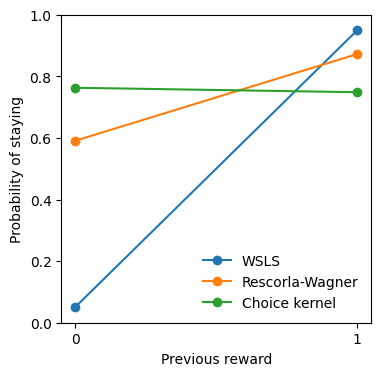

In [8]:
# Plot WSLS as a function of previous reward
plt.figure(figsize=(4, 4), dpi=100)
for i, prob in enumerate(wsls_probs):
    plt.plot([0, 1], prob, 'o-', label=model_names[i])
plt.xlabel('Previous reward')
plt.ylabel('Probability of staying')
plt.xticks([0, 1])
plt.legend(frameon=False)
plt.ylim(0, 1)

You should see that the choice kernel model leads to a reward-independent $p(stay)$, because choice probabilities are calculated independently of the previous reward. All other models show outcome-modulated behavior, with the starkest differences for the WSLS simulation.

*Take home message*: More broadly, these patterns of behavior can then be contrasted again actual behavioral data to inform about subjects' behavior. It is important to simulate your candidate models and plot their behavior before comparing them to actual data. 

### 3.3. Let's analyse the performance of the Rescorla Wagner Model: p(correct) analysis

For Rescorla Wagner, we are now interested in how learning rate and softmax inverse temperate affect the probability of choosing the arm with the highest reward. 

We will repeatedly perform a grid search over different parameter values (Nreps simulations with 100 trials per grid point) and store the mean $p(correct)$ across trials for each grid point and repetition.

In [11]:
# Parameter grid search for Rescorla-Wagner model
alphas = np.linspace(0.02, 1, 4)
betas = np.array([1, 2, 5, 10, 20])

In [12]:
# Let's first use only 10 simulations for each parameter combination. When your code works, increase to 1000.
num_reps = 1_000

# Initialize arrays to collect data
correct = np.zeros((len(alphas), len(betas), num_reps))
correct_early = np.zeros((len(alphas), len(betas), num_reps))
correct_late = np.zeros((len(alphas), len(betas), num_reps))

# Evaluation loop: grid-search over alpha and beta parameters for a large number of simulations
# on which you will then average.
for n in range(num_reps):
    for ai, alpha in enumerate(alphas):
        for bi, beta in enumerate(betas):
            actions, rewards = rw_model.simulate(num_trials, reward_probabilities, alpha, beta)
            correct[ai, bi, n] = np.mean(actions == np.argmax(reward_probabilities))
            correct_early[ai, bi, n] = np.mean(actions[:10] == np.argmax(reward_probabilities))
            correct_late[ai, bi, n] = np.mean(actions[-10:] == np.argmax(reward_probabilities))

Now plot $p(correct)$ as a function of $\alpha$ and $\beta$. Create the figure with two subplots: one for early, one for late trials.

As in Wilson & Collins box 2 figure 1, plot different levels of $\alpha$ on the x-axis and use different curves for $\beta$ levels.

/tmp/ipykernel_216479/1498445050.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('magma')(np.linspace(0, 0.6, len(betas)))


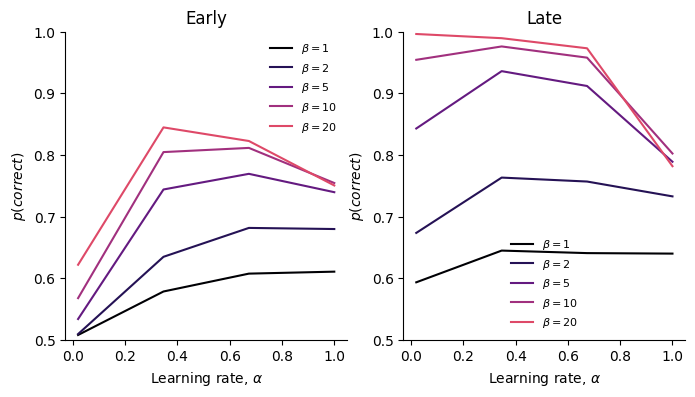

In [13]:
colors = cm.get_cmap('magma')(np.linspace(0, 0.6, len(betas)))

plt.figure(figsize=(8, 4), dpi=100)
plt.subplot(1, 2, 1)
plt.title('Early')
for ei, early in enumerate(np.mean(correct_early, axis=-1).T):
    plt.plot(alphas, early, color=colors[ei], label=rf'$\beta = {betas[ei]:.0f}$')
plt.xlabel(r'Learning rate, $\alpha$')
plt.ylabel(r'$p(correct)$')
plt.legend(frameon=False, fontsize=8)
plt.ylim(0.5, 1)

plt.subplot(1, 2, 2)
plt.title('Late')
for li, late in enumerate(np.mean(correct_late, axis=-1).T):
    plt.plot(alphas, late, color=colors[li], label=rf'$\beta = {betas[li]:.0f}$')
plt.xlabel(r'Learning rate, $\alpha$')
plt.ylabel(r'$p(correct)$')
plt.legend(frameon=False, fontsize=8)
plt.ylim(0.5, 1)

sns.despine()

How does performance change as a function of alpha and beta parameter values, for early and late trials?

The left graph shows that the learning rate is positively correlated with increases in early performance only for low $\beta$ values, or very low $\alpha$ values. For high $\beta$ values, there is a U-shaped relationship between learning rate and early speed of learning. The right graph shows that with high $\beta$ values, high learning rates negatively influence asymptotic behavior. Thus, both parameters interact to influence both the speed of learning and asymptotic performance. 

*Conclusion*: This kind of analysis will allow you to see qualitative differences between models, so that making their predictions in the experimental setup different. If the behavior of different models is not qualitatively different, this is a sign that you should try to design a better experiment. While not always possible, distinguishing between models on the basis of qualitative patterns in the data is preferable to quantitative model comparison. 

## 4. Parameter recovery

### 4.1. Simulation and fitting

Simulate Rescorla Wagner Model to generate synthetic data, then fit these data.

We will do this step by step. We will first simulate actions of the model for a given learning rate, $\alpha$, and softmax parameter, $\beta$.			

After simulating the model, we will fit the parameters using a maximum likelihood approach to get estimated values $\hat{\alpha}$ and $\hat{\beta}$. 

Fit the simulated data. 

Fit Rescorla Wagner by calling the `fit()` method for that model, `rw_model.fit()`, which takes as inputs actions and rewards. We will not focus on the goodness of fit here, but you should take a moment to look at the specification in `.fit()` and `likelihood()` methods of the model in `models.py`.

In [14]:
# Parameter recovery
num_reps = 100
alphas = np.random.rand(num_reps)
betas = 10 * np.random.exponential(size=num_reps)

recovered_params = []
for n in range(num_reps):
    np.random.seed(n + 1000)
    actions, rewards = rw_model.simulate(num_trials, reward_probabilities, alphas[n], betas[n])
    _, params, _ = rw_model.fit(actions, rewards)
    recovered_params.append(params)

recovered_params = np.array(recovered_params)

/home/nisheet/projects/BAMB2024/day2_reinforcement_learning/part2_fitting_rl_models/models.py:92: RuntimeWarning: overflow encountered in exp
  p = np.exp(beta * Q) / np.sum(np.exp(beta * Q))
/home/nisheet/projects/BAMB2024/day2_reinforcement_learning/part2_fitting_rl_models/models.py:92: RuntimeWarning: invalid value encountered in divide
  p = np.exp(beta * Q) / np.sum(np.exp(beta * Q))


### 4.1. Parameter recovery plots

We would like to visualise the fitted parameter values as a function of the generating parameter values. We will have one data point for each iteration. Here, you should use the generating values and the fitted values that you have stored in the section above. You should create two subplots, one for each parameter.

/tmp/ipykernel_216479/520215096.py:11: RuntimeWarning: divide by zero encountered in log
  ax.plot(np.log(betas), np.log(recovered_params[:, 1]), 'o', color='darkred', alpha=0.7)


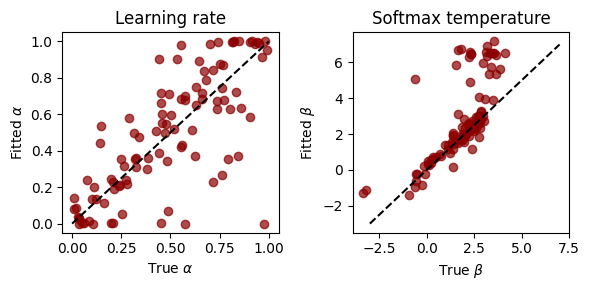

In [15]:
plt.figure(figsize=(6, 3), dpi=100)
plt.subplot(121)
plt.title('Learning rate')
plt.plot(alphas, recovered_params[:, 0], 'o', color='darkred', alpha=0.7)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel(r'True $\alpha$')
plt.ylabel(r'Fitted $\alpha$')

ax = plt.subplot(122)
ax.set_title('Softmax temperature')
ax.plot(np.log(betas), np.log(recovered_params[:, 1]), 'o', color='darkred', alpha=0.7)
plt.plot([-3, 7], [-3, 7], 'k--')
ax.set_xlabel(r'True $\beta$')
ax.set_ylabel(r'Fitted $\beta$')

plt.tight_layout()

Do you observe a fairly good agreement between the simulated and fit parameter values?

The plot makes any correlations clear, and also reveals whether the correlation holds in some parameter regimes but not others. It also reveals any existing bias (e.g. a tendency to recover higher or lower values in average).

Here we can see that the fit for $\beta$ is best with a range, $0.1 < \beta < 10$ and that outside this range, the correspondence between simulation and fit is not as good.

Depending on the values of $\beta$ that we obtain when fitting human behavior, this worse correspondence at small and large $\beta$ may or may not be problematic. It may be a good idea to use the range of parameters obtained from fitting the real data to test the quality of recovery within the range that matters. 

Reliable parameter recovery is particularly important for look at inter-individual differences in relation to questionnaire scores or brain data.

## 5. Model recovery: confusion matrix

To illustrate model recovery, here we will simulate behavior of our three models on the two-armed bandits task. 

As before, the means $\mu$ can be set at 0.2 and 0.8, and the number of trials at $T = 1000$. For each simulation, model parameters can be sampled randomly for each model. 

Each simulated data set will then be fit to each of the given models, to determine which model fit best (according to BIC). This process will be repeated 100 times (number of "repetitions" or "counts") to compute the confusion matrix.

In [16]:
# Model comparison
num_trials = 1_000
num_counts = 10

Let's build a confusion matrix. It quantifies the probability that each model is the best fit to data generated from the other models. In a perfect world the confusion matrix will be the identity matrix, but in practice this is not always the case.

How to read the confusion matrix? Given a winning model (a particular column), it tells you the likelihood of each ground-truth model (each row) to have generated the data (basically, the columns are more important than the rows).

In [17]:
models = [wsls_model, rw_model, ck_model]
confusion_matrix = np.zeros((3, 3))

for n in range(num_counts):
    np.random.seed(n)
    
    for i, model in enumerate(models):
        if isinstance(model, WinStayLoseSwitch):
            actions, rewards = model.simulate(num_trials, reward_probabilities, epsilon=np.random.uniform())
        else:
            actions, rewards = model.simulate(num_trials, reward_probabilities, alpha=np.random.uniform(), beta=1+np.random.exponential())
        
        fit_results = [m.fit(actions, rewards) for m in models]
        best_model = np.argmin([r[0] for r in fit_results])
        confusion_matrix[i, best_model] += 1

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


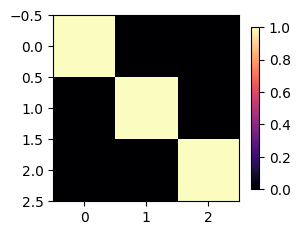

In [18]:
# normalize confusion matrix
confusion_matrix_norm = confusion_matrix / num_counts

# print values to see
print(confusion_matrix_norm)

# plot values
plt.figure(figsize=(3, 3), dpi=100)
plt.imshow(confusion_matrix_norm, vmin=0, vmax=1, cmap='magma')
plt.colorbar(shrink=0.7)

- Does your confusion matrix have large off-diagonal components? If so, this indicates that you have a problem with model recovery.

- If you change the generating parameters, in particular the softmax temperature, do you get a better confusion matrix?

You can observe then that the confusion matrix can be so dependent on the simulating parameter values means that it is crucial to match the simulation parameters to the actual fit parameters of your actual behavioral data (when you have some) as best as possible. Models that are identifiable in one parameter regime may be impossible to distinguish in another regime.

A final note to remember: As with all model comparisons, it only tells you which model fits best of the models you considered. In and of itself, this is rather limited information as there are infinitely many other models that you did not consider. This makes it imperative to start with a good set of models initially, that rigorously capture the competing hypotheses.